## Modules

In [28]:
import numpy as np
import pandas as pd
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,SimpleRNN
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [29]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [30]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [31]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [32]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [33]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [34]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [35]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [36]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


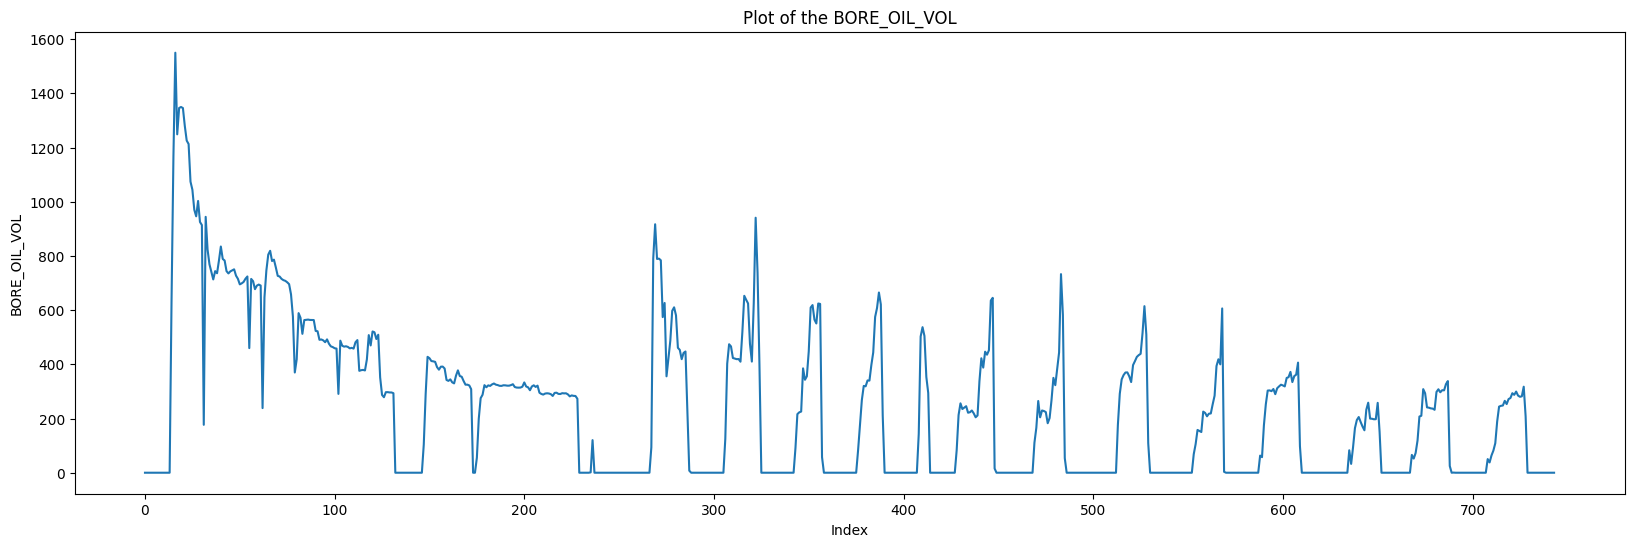

In [37]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [38]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [39]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


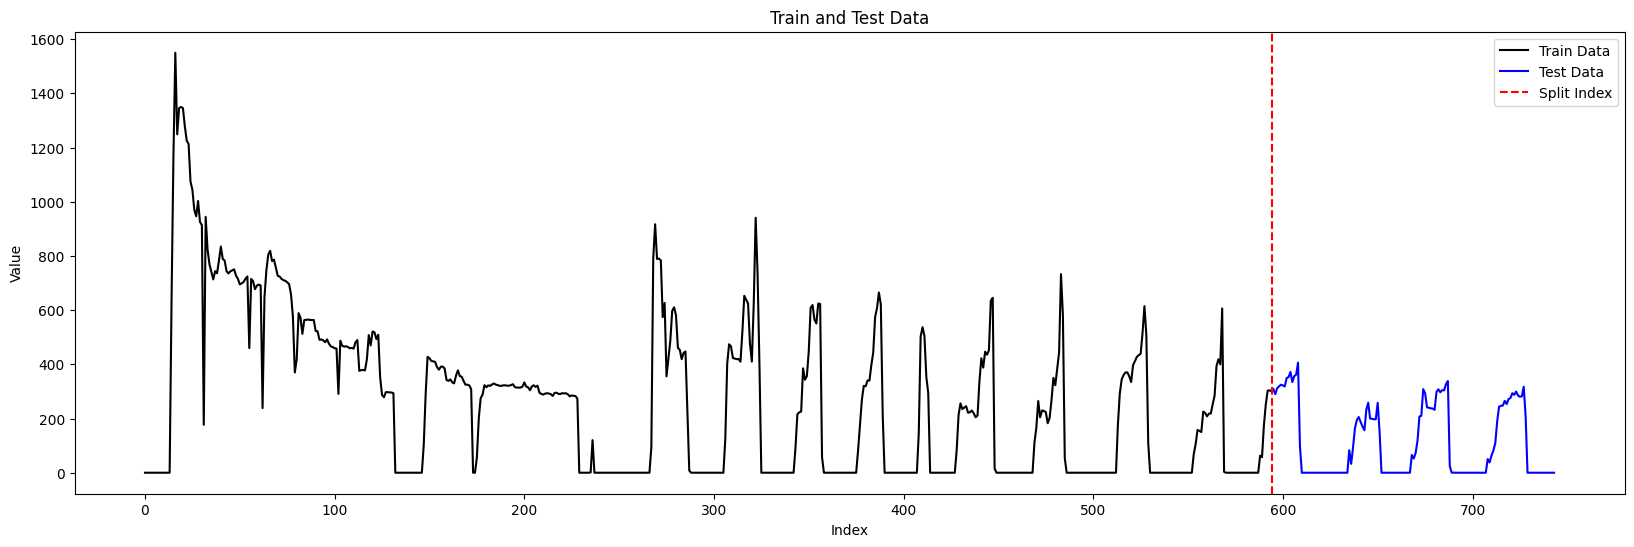

In [40]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [41]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [42]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [43]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [44]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [45]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [46]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [47]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [48]:
# pip install optuna
!pip install optuna-integration

In [49]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [50]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [51]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(SimpleRNN(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(SimpleRNN(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [52]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-10-31 13:17:18,357] A new study created in memory with name: no-name-3b9096b5-34eb-4155-ae05-7148e40eba46


In [53]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://93cc0826-7367-4ed2-b7f8-0811dfffc19c/assets


[I 2023-10-31 17:48:42,046] Trial 0 finished with value: 0.06018039211630821 and parameters: {'window_size': 25, 'batch_size': 3, 'n_lstm_layers': 11, 'lstm_units': 192, 'learning_rate': 0.004501699349979225}. Best is trial 0 with value: 0.06018039211630821.


INFO:tensorflow:Assets written to: ram://e738093c-4e93-4601-b29f-a1da6127727c/assets


[I 2023-11-01 00:48:44,619] Trial 1 finished with value: 0.008146547712385654 and parameters: {'window_size': 54, 'batch_size': 8, 'n_lstm_layers': 14, 'lstm_units': 98, 'learning_rate': 0.009123638610735774}. Best is trial 1 with value: 0.008146547712385654.


INFO:tensorflow:Assets written to: ram://270b5977-4b5b-4cfc-b8d5-7ddfab65f07b/assets


[I 2023-11-01 02:30:31,281] Trial 2 finished with value: 0.01714245043694973 and parameters: {'window_size': 30, 'batch_size': 7, 'n_lstm_layers': 5, 'lstm_units': 122, 'learning_rate': 0.009572157697288825}. Best is trial 1 with value: 0.008146547712385654.


INFO:tensorflow:Assets written to: ram://8e3d2fda-94bf-485f-9db1-f320b2788436/assets


[I 2023-11-01 07:31:10,692] Trial 3 finished with value: 0.026721632108092308 and parameters: {'window_size': 11, 'batch_size': 2, 'n_lstm_layers': 19, 'lstm_units': 81, 'learning_rate': 0.0012811029248400976}. Best is trial 1 with value: 0.008146547712385654.


INFO:tensorflow:Assets written to: ram://43ee5287-7f11-4deb-8a76-a705251e2331/assets


[I 2023-11-01 07:38:47,999] Trial 4 finished with value: 0.00217945477925241 and parameters: {'window_size': 10, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 83, 'learning_rate': 0.0006329157259476952}. Best is trial 4 with value: 0.00217945477925241.
[I 2023-11-01 07:40:12,522] Trial 5 pruned. 


INFO:tensorflow:Assets written to: ram://5d7466cd-3287-4f0d-a736-5680880e8844/assets


[I 2023-11-01 08:06:00,888] Trial 6 finished with value: 0.011076030321419239 and parameters: {'window_size': 23, 'batch_size': 14, 'n_lstm_layers': 3, 'lstm_units': 157, 'learning_rate': 0.008481786812437934}. Best is trial 4 with value: 0.00217945477925241.


INFO:tensorflow:Assets written to: ram://bd7d8a82-ae24-4256-b813-3c758527c019/assets


[I 2023-11-01 08:45:35,230] Trial 7 finished with value: 0.08102390170097351 and parameters: {'window_size': 16, 'batch_size': 10, 'n_lstm_layers': 5, 'lstm_units': 209, 'learning_rate': 0.006180529646207105}. Best is trial 4 with value: 0.00217945477925241.
[I 2023-11-01 08:46:19,004] Trial 8 pruned. 
[I 2023-11-01 08:48:07,012] Trial 9 pruned. 


INFO:tensorflow:Assets written to: ram://f7c7e598-1a43-42ec-9648-b0b87ed7983a/assets


[I 2023-11-01 08:49:32,125] Trial 10 finished with value: 0.0011775551829487085 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 37, 'learning_rate': 0.0002021172093719329}. Best is trial 10 with value: 0.0011775551829487085.


INFO:tensorflow:Assets written to: ram://46e63371-3178-4be7-8a12-7e9da8076fd8/assets


[I 2023-11-01 08:50:57,744] Trial 11 finished with value: 0.0011512812925502658 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 33, 'learning_rate': 0.00032613638688630715}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://6061fca6-aec2-4465-b0c7-5a2e9387e2ec/assets


[I 2023-11-01 08:52:09,395] Trial 12 finished with value: 0.0011789615964516997 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 32, 'learning_rate': 0.0001924482058384996}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 08:52:15,310] Trial 13 pruned. 
[I 2023-11-01 08:52:25,204] Trial 14 pruned. 
[I 2023-11-01 08:52:28,189] Trial 15 pruned. 
[I 2023-11-01 08:52:36,739] Trial 16 pruned. 
[I 2023-11-01 08:53:00,699] Trial 17 pruned. 


INFO:tensorflow:Assets written to: ram://c3c8c002-7216-4690-8958-e3e4f426564f/assets


[I 2023-11-01 08:56:12,289] Trial 18 finished with value: 0.0016516968607902527 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 6, 'lstm_units': 55, 'learning_rate': 0.0013609412072665946}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 08:56:17,265] Trial 19 pruned. 
[I 2023-11-01 08:56:43,077] Trial 20 pruned. 


INFO:tensorflow:Assets written to: ram://5a4415ab-0e00-43be-9147-79ab49e1f2cf/assets


[I 2023-11-01 08:58:54,954] Trial 21 finished with value: 0.0014383381931111217 and parameters: {'window_size': 4, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 32, 'learning_rate': 0.0007313450633662267}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 08:58:57,002] Trial 22 pruned. 
[I 2023-11-01 08:59:01,395] Trial 23 pruned. 
[I 2023-11-01 08:59:06,818] Trial 24 pruned. 
[I 2023-11-01 08:59:16,243] Trial 25 pruned. 
[I 2023-11-01 08:59:18,494] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://834aa0df-dc32-4fad-a264-dfcd49af0de9/assets


[I 2023-11-01 09:41:37,849] Trial 27 finished with value: 0.028115341439843178 and parameters: {'window_size': 19, 'batch_size': 12, 'n_lstm_layers': 6, 'lstm_units': 72, 'learning_rate': 0.0009488938735588694}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://410e9978-0335-4f25-bbaa-c92e99ddf952/assets


[I 2023-11-01 09:48:28,899] Trial 28 finished with value: 0.0015514383558183908 and parameters: {'window_size': 7, 'batch_size': 17, 'n_lstm_layers': 3, 'lstm_units': 247, 'learning_rate': 0.00010768627774935155}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 09:48:40,824] Trial 29 pruned. 
[I 2023-11-01 09:48:47,389] Trial 30 pruned. 


INFO:tensorflow:Assets written to: ram://f25ab7be-e5eb-450a-b018-2ba24b45d932/assets


[I 2023-11-01 09:51:20,710] Trial 31 finished with value: 0.0018298428039997816 and parameters: {'window_size': 5, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 35, 'learning_rate': 0.0006844067886151053}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://250d17d9-f7aa-45a6-a553-8ac0606d73ef/assets


[I 2023-11-01 09:53:47,480] Trial 32 finished with value: 0.0011521326377987862 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 32, 'learning_rate': 0.0008375464397539474}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 09:53:52,455] Trial 33 pruned. 


INFO:tensorflow:Assets written to: ram://6bba8cf4-3b28-4d77-b1a9-c7eea2f7676b/assets


[I 2023-11-01 09:56:19,837] Trial 34 finished with value: 0.0012247009435668588 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 68, 'learning_rate': 0.0018477697791920902}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 09:56:26,214] Trial 35 pruned. 
[I 2023-11-01 09:56:45,816] Trial 36 pruned. 
[I 2023-11-01 09:56:50,927] Trial 37 pruned. 
[I 2023-11-01 09:57:09,133] Trial 38 pruned. 
[I 2023-11-01 09:57:16,822] Trial 39 pruned. 
[I 2023-11-01 09:57:19,807] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://5351fd60-d717-4f39-b0b7-94b9f2ae2747/assets


[I 2023-11-01 09:59:20,493] Trial 41 finished with value: 0.0012238937197253108 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 68, 'learning_rate': 0.0015876884929710005}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://b5d4ef9a-7b8d-468b-ac81-11d03d3cb207/assets


[I 2023-11-01 10:01:24,379] Trial 42 finished with value: 0.0011897834483534098 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 4, 'lstm_units': 42, 'learning_rate': 0.000592817774813901}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 10:01:28,740] Trial 43 pruned. 
[I 2023-11-01 10:01:32,226] Trial 44 pruned. 
[I 2023-11-01 10:01:57,925] Trial 45 pruned. 


INFO:tensorflow:Assets written to: ram://ac5fc475-ff9f-4c92-8269-4aef3c3ac618/assets


[I 2023-11-01 10:04:34,740] Trial 46 finished with value: 0.001317581976763904 and parameters: {'window_size': 4, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 178, 'learning_rate': 0.000567426548423018}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 10:04:39,070] Trial 47 pruned. 
[I 2023-11-01 10:04:44,603] Trial 48 pruned. 
[I 2023-11-01 10:04:55,544] Trial 49 pruned. 


INFO:tensorflow:Assets written to: ram://2c24c432-313f-471d-8960-94cbe9ac7480/assets


[I 2023-11-01 10:08:53,578] Trial 50 finished with value: 0.010251520201563835 and parameters: {'window_size': 5, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 111, 'learning_rate': 0.002921562839278187}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://fbbd386a-a555-4907-9c25-e9f5ecce9787/assets


[I 2023-11-01 10:10:50,777] Trial 51 finished with value: 0.0011553873773664236 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 40, 'learning_rate': 0.0016633838955815417}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 10:10:52,622] Trial 52 pruned. 


INFO:tensorflow:Assets written to: ram://73432b01-7f01-49aa-a464-7d339b39a001/assets


[I 2023-11-01 10:14:05,723] Trial 53 finished with value: 0.001327330945059657 and parameters: {'window_size': 4, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 60, 'learning_rate': 0.0009232449391352309}. Best is trial 11 with value: 0.0011512812925502658.


INFO:tensorflow:Assets written to: ram://8d94d5be-a560-4b8a-9a27-ba8bcc93957a/assets


[I 2023-11-01 10:17:19,380] Trial 54 finished with value: 0.001235269010066986 and parameters: {'window_size': 7, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 153, 'learning_rate': 0.00039143624201714493}. Best is trial 11 with value: 0.0011512812925502658.
[I 2023-11-01 10:17:27,210] Trial 55 pruned. 
[I 2023-11-01 10:17:33,275] Trial 56 pruned. 
[I 2023-11-01 10:17:38,324] Trial 57 pruned. 


INFO:tensorflow:Assets written to: ram://63d26ba9-10ae-42c1-a59c-2d2f9abc3924/assets


[I 2023-11-01 10:19:14,758] Trial 58 finished with value: 0.0011100838892161846 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.0013873266466639183}. Best is trial 58 with value: 0.0011100838892161846.
[I 2023-11-01 10:19:17,440] Trial 59 pruned. 
[I 2023-11-01 10:19:25,225] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://ac62d93d-13a1-4cf7-8520-3170194d5e82/assets


[I 2023-11-01 10:20:58,797] Trial 61 finished with value: 0.0012298714136704803 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 40, 'learning_rate': 0.0003909506730206024}. Best is trial 58 with value: 0.0011100838892161846.
[I 2023-11-01 10:21:00,845] Trial 62 pruned. 


INFO:tensorflow:Assets written to: ram://f3e914bc-dd3a-4858-b7e7-1184a30b43e3/assets


[I 2023-11-01 10:23:20,769] Trial 63 finished with value: 0.001133566489443183 and parameters: {'window_size': 3, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 63, 'learning_rate': 0.0007706027652877447}. Best is trial 58 with value: 0.0011100838892161846.
[I 2023-11-01 10:23:23,671] Trial 64 pruned. 


INFO:tensorflow:Assets written to: ram://3c58ffb9-4399-44b7-a537-479562c0e158/assets


[I 2023-11-01 10:27:04,993] Trial 65 finished with value: 0.0013488034019246697 and parameters: {'window_size': 4, 'batch_size': 20, 'n_lstm_layers': 3, 'lstm_units': 76, 'learning_rate': 0.0014328347860095108}. Best is trial 58 with value: 0.0011100838892161846.
[I 2023-11-01 10:27:18,245] Trial 66 pruned. 
[I 2023-11-01 10:27:20,912] Trial 67 pruned. 
[I 2023-11-01 10:28:05,780] Trial 68 pruned. 
[I 2023-11-01 10:28:09,735] Trial 69 pruned. 
[I 2023-11-01 10:28:12,205] Trial 70 pruned. 


INFO:tensorflow:Assets written to: ram://a5e17b13-b349-4218-a988-54f345bd942e/assets


[I 2023-11-01 10:31:53,089] Trial 71 finished with value: 0.0012357464293017983 and parameters: {'window_size': 3, 'batch_size': 19, 'n_lstm_layers': 4, 'lstm_units': 49, 'learning_rate': 0.0007000667020310788}. Best is trial 58 with value: 0.0011100838892161846.


INFO:tensorflow:Assets written to: ram://5718f012-aa8d-458f-9089-35a7152dd1d7/assets


[I 2023-11-01 10:34:00,404] Trial 72 finished with value: 0.001131060067564249 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 3, 'lstm_units': 39, 'learning_rate': 0.0006589297101086977}. Best is trial 58 with value: 0.0011100838892161846.
[I 2023-11-01 10:34:11,246] Trial 73 pruned. 
[I 2023-11-01 10:34:14,919] Trial 74 pruned. 


INFO:tensorflow:Assets written to: ram://144fa763-0b30-47fa-bde2-35a60dc1a388/assets


[I 2023-11-01 10:40:15,018] Trial 75 finished with value: 0.0012818138347938657 and parameters: {'window_size': 4, 'batch_size': 9, 'n_lstm_layers': 2, 'lstm_units': 32, 'learning_rate': 0.001183121671831293}. Best is trial 58 with value: 0.0011100838892161846.


INFO:tensorflow:Assets written to: ram://7b1dbd54-2fbc-4916-a8bf-c11f32c3ee88/assets


[I 2023-11-01 10:41:26,692] Trial 76 finished with value: 0.0010950384894385934 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 44, 'learning_rate': 0.0013524476064303256}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://6b566e69-d580-4e46-9670-595fc5bbdaf4/assets


[I 2023-11-01 10:43:24,309] Trial 77 finished with value: 0.0011353951413184404 and parameters: {'window_size': 3, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.001736702752513559}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:43:37,894] Trial 78 pruned. 
[I 2023-11-01 10:43:49,420] Trial 79 pruned. 
[I 2023-11-01 10:43:56,266] Trial 80 pruned. 


INFO:tensorflow:Assets written to: ram://c5b7af91-ed7f-4b4e-b951-5f533f848bdf/assets


[I 2023-11-01 10:45:29,638] Trial 81 finished with value: 0.0011164392344653606 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 55, 'learning_rate': 0.001234001747656315}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:45:33,984] Trial 82 pruned. 


INFO:tensorflow:Assets written to: ram://e5356a86-b582-4f37-a4c4-57e1f88d78c3/assets


[I 2023-11-01 10:47:11,808] Trial 83 finished with value: 0.0011419433867558837 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 64, 'learning_rate': 0.0017806984395921043}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:47:13,814] Trial 84 pruned. 
[I 2023-11-01 10:47:16,065] Trial 85 pruned. 
[I 2023-11-01 10:47:31,974] Trial 86 pruned. 
[I 2023-11-01 10:47:35,475] Trial 87 pruned. 
[I 2023-11-01 10:47:37,790] Trial 88 pruned. 
[I 2023-11-01 10:47:46,844] Trial 89 pruned. 


INFO:tensorflow:Assets written to: ram://54aff634-e63a-4e0d-af97-44f2f7bbd7b5/assets


[I 2023-11-01 10:49:15,271] Trial 90 finished with value: 0.0011196674313396215 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 59, 'learning_rate': 0.0006349662423446416}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://42deebcb-4f36-4366-a9cd-9be39e69d342/assets


[I 2023-11-01 10:50:43,232] Trial 91 finished with value: 0.0011196410050615668 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 59, 'learning_rate': 0.0005885809011427013}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:50:45,937] Trial 92 pruned. 
[I 2023-11-01 10:50:47,859] Trial 93 pruned. 


INFO:tensorflow:Assets written to: ram://384a534a-1e8d-464a-90fc-ddaef66229a2/assets


[I 2023-11-01 10:52:44,479] Trial 94 finished with value: 0.0011464270064607263 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 106, 'learning_rate': 0.0014016452566461906}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:52:48,047] Trial 95 pruned. 


INFO:tensorflow:Assets written to: ram://4b8389ff-7250-4654-8e1a-579cfb09a974/assets


[I 2023-11-01 10:54:47,363] Trial 96 finished with value: 0.0011238721199333668 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 131, 'learning_rate': 0.0012995662145137029}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:54:54,937] Trial 97 pruned. 
[I 2023-11-01 10:54:57,985] Trial 98 pruned. 
[I 2023-11-01 10:55:00,769] Trial 99 pruned. 
[I 2023-11-01 10:55:06,460] Trial 100 pruned. 


INFO:tensorflow:Assets written to: ram://7c5513e1-a3ba-4355-9e75-3fc77617f74c/assets


[I 2023-11-01 10:57:07,138] Trial 101 finished with value: 0.001117427833378315 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 122, 'learning_rate': 0.0015154383911673874}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 10:57:09,011] Trial 102 pruned. 
[I 2023-11-01 10:57:11,698] Trial 103 pruned. 
[I 2023-11-01 10:57:15,778] Trial 104 pruned. 
[I 2023-11-01 10:57:22,047] Trial 105 pruned. 


INFO:tensorflow:Assets written to: ram://696f16c5-2689-418b-88e4-33ebb3e3e7c4/assets


[I 2023-11-01 10:59:58,046] Trial 106 finished with value: 0.0012699785875156522 and parameters: {'window_size': 4, 'batch_size': 16, 'n_lstm_layers': 1, 'lstm_units': 120, 'learning_rate': 0.0018797495662243988}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:00:20,812] Trial 107 pruned. 


INFO:tensorflow:Assets written to: ram://7615e403-ea72-4574-ad03-b0ae11bc8965/assets


[I 2023-11-01 11:02:26,259] Trial 108 finished with value: 0.0013489571865648031 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 3, 'lstm_units': 53, 'learning_rate': 0.0015917940542308263}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:02:29,571] Trial 109 pruned. 
[I 2023-11-01 11:02:32,727] Trial 110 pruned. 
[I 2023-11-01 11:02:35,338] Trial 111 pruned. 
[I 2023-11-01 11:02:37,824] Trial 112 pruned. 
[I 2023-11-01 11:02:46,977] Trial 113 pruned. 
[I 2023-11-01 11:02:55,309] Trial 114 pruned. 
[I 2023-11-01 11:02:57,637] Trial 115 pruned. 
[I 2023-11-01 11:02:59,888] Trial 116 pruned. 


INFO:tensorflow:Assets written to: ram://f7dd5a04-cfdb-4fbc-b72d-c4205b8f3d98/assets


[I 2023-11-01 11:04:36,769] Trial 117 finished with value: 0.0011716169537976384 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 1, 'lstm_units': 117, 'learning_rate': 0.0012926588585120268}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:04:44,809] Trial 118 pruned. 
[I 2023-11-01 11:04:47,654] Trial 119 pruned. 
[I 2023-11-01 11:04:51,046] Trial 120 pruned. 
[I 2023-11-01 11:04:52,890] Trial 121 pruned. 
[I 2023-11-01 11:04:56,098] Trial 122 pruned. 
[I 2023-11-01 11:04:58,130] Trial 123 pruned. 
[I 2023-11-01 11:05:01,053] Trial 124 pruned. 
[I 2023-11-01 11:05:03,007] Trial 125 pruned. 
[I 2023-11-01 11:05:09,524] Trial 126 pruned. 
[I 2023-11-01 11:05:13,588] Trial 127 pruned. 
[I 2023-11-01 11:05:15,633] Trial 128 pruned. 


INFO:tensorflow:Assets written to: ram://42412ed7-dc75-48f2-bd83-eb5356596fc2/assets


[I 2023-11-01 11:07:02,426] Trial 129 finished with value: 0.0013932330766692758 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 152, 'learning_rate': 0.0014120604789779688}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:07:07,764] Trial 130 pruned. 
[I 2023-11-01 11:07:10,359] Trial 131 pruned. 
[I 2023-11-01 11:07:17,602] Trial 132 pruned. 
[I 2023-11-01 11:07:20,118] Trial 133 pruned. 
[I 2023-11-01 11:07:22,540] Trial 134 pruned. 
[I 2023-11-01 11:07:25,370] Trial 135 pruned. 
[I 2023-11-01 11:07:29,717] Trial 136 pruned. 
[I 2023-11-01 11:07:34,323] Trial 137 pruned. 
[I 2023-11-01 11:07:36,871] Trial 138 pruned. 


INFO:tensorflow:Assets written to: ram://b72a6903-7be9-43dc-8b93-5a677b8e2b1b/assets


[I 2023-11-01 11:09:37,402] Trial 139 finished with value: 0.0011224602349102497 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 2, 'lstm_units': 134, 'learning_rate': 0.0003558994061353506}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://79c10d96-3857-48e4-9658-3f32bd5345a9/assets


[I 2023-11-01 11:12:14,245] Trial 140 finished with value: 0.0011106757447123528 and parameters: {'window_size': 2, 'batch_size': 16, 'n_lstm_layers': 3, 'lstm_units': 137, 'learning_rate': 0.00032556166043523106}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:12:18,161] Trial 141 pruned. 
[I 2023-11-01 11:12:21,523] Trial 142 pruned. 
[I 2023-11-01 11:12:26,478] Trial 143 pruned. 
[I 2023-11-01 11:12:29,620] Trial 144 pruned. 
[I 2023-11-01 11:12:31,715] Trial 145 pruned. 
[I 2023-11-01 11:12:33,684] Trial 146 pruned. 
[I 2023-11-01 11:12:36,529] Trial 147 pruned. 
[I 2023-11-01 11:12:48,362] Trial 148 pruned. 


INFO:tensorflow:Assets written to: ram://368e112f-e2d9-445d-a5cb-398bcaf4cc4e/assets


[I 2023-11-01 11:14:56,225] Trial 149 finished with value: 0.0011416437337175012 and parameters: {'window_size': 2, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 74, 'learning_rate': 0.0017504928379132828}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://1009e0fc-0781-434e-83fe-6fdff707cc73/assets


[I 2023-11-01 11:18:07,026] Trial 150 finished with value: 0.0011614497052505612 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 4, 'lstm_units': 69, 'learning_rate': 0.0020668124003915553}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:18:09,581] Trial 151 pruned. 
[I 2023-11-01 11:18:13,207] Trial 152 pruned. 


INFO:tensorflow:Assets written to: ram://5d0384a6-a27a-498c-9618-3f24ac231522/assets


[I 2023-11-01 11:20:01,304] Trial 153 finished with value: 0.0012422307627275586 and parameters: {'window_size': 2, 'batch_size': 15, 'n_lstm_layers': 1, 'lstm_units': 122, 'learning_rate': 0.0015375337438974413}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:20:04,619] Trial 154 pruned. 
[I 2023-11-01 11:20:07,856] Trial 155 pruned. 
[I 2023-11-01 11:20:11,872] Trial 156 pruned. 
[I 2023-11-01 11:20:16,749] Trial 157 pruned. 
[I 2023-11-01 11:20:19,906] Trial 158 pruned. 
[I 2023-11-01 11:20:34,337] Trial 159 pruned. 
[I 2023-11-01 11:20:40,668] Trial 160 pruned. 
[I 2023-11-01 11:20:45,749] Trial 161 pruned. 
[I 2023-11-01 11:20:48,829] Trial 162 pruned. 
[I 2023-11-01 11:20:51,283] Trial 163 pruned. 
[I 2023-11-01 11:20:54,754] Trial 164 pruned. 
[I 2023-11-01 11:20:58,083] Trial 165 pruned. 


INFO:tensorflow:Assets written to: ram://b5cb055e-0f36-488f-958c-ddcc7348bcff/assets


[I 2023-11-01 11:22:47,658] Trial 166 finished with value: 0.0013523262459784746 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 255, 'learning_rate': 0.0008936831367511731}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:22:49,696] Trial 167 pruned. 
[I 2023-11-01 11:22:59,590] Trial 168 pruned. 


INFO:tensorflow:Assets written to: ram://ae76aba0-d04d-4a0f-8d18-552977bdb578/assets


[I 2023-11-01 11:25:24,921] Trial 169 finished with value: 0.001216247444972396 and parameters: {'window_size': 2, 'batch_size': 17, 'n_lstm_layers': 3, 'lstm_units': 42, 'learning_rate': 0.003810343782229025}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:25:28,765] Trial 170 pruned. 


INFO:tensorflow:Assets written to: ram://d0d45650-5640-480a-a939-8d3fa8fd9f2e/assets


[I 2023-11-01 11:27:25,958] Trial 171 finished with value: 0.0013623067643493414 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 39, 'learning_rate': 0.0020169206986270843}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:27:29,673] Trial 172 pruned. 
[I 2023-11-01 11:27:32,377] Trial 173 pruned. 
[I 2023-11-01 11:27:36,489] Trial 174 pruned. 
[I 2023-11-01 11:27:39,030] Trial 175 pruned. 
[I 2023-11-01 11:27:41,656] Trial 176 pruned. 
[I 2023-11-01 11:27:47,315] Trial 177 pruned. 


INFO:tensorflow:Assets written to: ram://746355bd-96ae-4987-852b-64e7a465fd3c/assets


[I 2023-11-01 11:29:44,877] Trial 178 finished with value: 0.0011538701364770532 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 143, 'learning_rate': 0.0024583768824864667}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:29:48,535] Trial 179 pruned. 
[I 2023-11-01 11:29:57,324] Trial 180 pruned. 


INFO:tensorflow:Assets written to: ram://4f98dc6c-84bf-4aa5-9b27-6f4ce72cb3d9/assets


[I 2023-11-01 11:31:53,870] Trial 181 finished with value: 0.0011751848505809903 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 146, 'learning_rate': 0.001942292684064424}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://cacb0e87-4159-453a-9ed0-c076ce73aa34/assets


[I 2023-11-01 11:33:51,000] Trial 182 finished with value: 0.0012951191747561097 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 63, 'learning_rate': 0.0013409583100726097}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:33:53,626] Trial 183 pruned. 
[I 2023-11-01 11:33:56,727] Trial 184 pruned. 
[I 2023-11-01 11:33:59,495] Trial 185 pruned. 


INFO:tensorflow:Assets written to: ram://55660d44-d6dc-4849-ae20-275cf73318af/assets


[I 2023-11-01 11:35:11,421] Trial 186 finished with value: 0.0011155764805153012 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 69, 'learning_rate': 0.0008311559863421184}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:35:13,305] Trial 187 pruned. 


INFO:tensorflow:Assets written to: ram://d132d407-02ce-4a83-88d8-c809d618bac5/assets


[I 2023-11-01 11:36:25,123] Trial 188 finished with value: 0.0011200468288734555 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.000911920590045827}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:36:27,850] Trial 189 pruned. 
[I 2023-11-01 11:36:29,835] Trial 190 pruned. 
[I 2023-11-01 11:36:31,554] Trial 191 pruned. 
[I 2023-11-01 11:36:33,633] Trial 192 pruned. 
[I 2023-11-01 11:36:36,236] Trial 193 pruned. 


INFO:tensorflow:Assets written to: ram://c2fce792-b29a-4283-8f1a-f71fa2e32284/assets


[I 2023-11-01 11:38:01,415] Trial 194 finished with value: 0.0011435308260843158 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 62, 'learning_rate': 0.0012162934396323102}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:38:03,824] Trial 195 pruned. 
[I 2023-11-01 11:38:05,715] Trial 196 pruned. 
[I 2023-11-01 11:38:07,576] Trial 197 pruned. 
[I 2023-11-01 11:38:15,610] Trial 198 pruned. 
[I 2023-11-01 11:38:22,006] Trial 199 pruned. 


INFO:tensorflow:Assets written to: ram://066a3bec-22f6-4afb-9557-0741d334feff/assets


[I 2023-11-01 11:45:35,065] Trial 200 finished with value: 0.001350398757494986 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 16, 'lstm_units': 62, 'learning_rate': 0.0003614617005789743}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://934ad7ba-c262-4b01-907f-7c551ee444fe/assets


[I 2023-11-01 11:47:32,872] Trial 201 finished with value: 0.0011594860116019845 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 2, 'lstm_units': 224, 'learning_rate': 0.0007682491674492469}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:47:35,967] Trial 202 pruned. 


INFO:tensorflow:Assets written to: ram://2873629b-8741-4150-a41e-460dc9f41e12/assets


[I 2023-11-01 11:49:43,459] Trial 203 finished with value: 0.001354816136881709 and parameters: {'window_size': 2, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 55, 'learning_rate': 0.0015268825132299015}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:49:47,085] Trial 204 pruned. 
[I 2023-11-01 11:49:51,680] Trial 205 pruned. 
[I 2023-11-01 11:49:54,431] Trial 206 pruned. 
[I 2023-11-01 11:49:56,931] Trial 207 pruned. 
[I 2023-11-01 11:49:58,885] Trial 208 pruned. 
[I 2023-11-01 11:50:01,605] Trial 209 pruned. 
[I 2023-11-01 11:50:06,215] Trial 210 pruned. 
[I 2023-11-01 11:50:10,108] Trial 211 pruned. 


INFO:tensorflow:Assets written to: ram://0d688cb1-02ed-4615-96e5-8d84208edf74/assets


[I 2023-11-01 11:51:38,804] Trial 212 finished with value: 0.0011498765088617802 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 37, 'learning_rate': 0.0018141608487131052}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://abfbced5-a4aa-4e08-a1e6-578f2bfa8ec3/assets


[I 2023-11-01 11:52:51,373] Trial 213 finished with value: 0.0011103464057669044 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 58, 'learning_rate': 0.0017257528794893703}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://bfb66370-a212-4eda-96cb-588a8c78b9b0/assets


[I 2023-11-01 11:54:43,718] Trial 214 finished with value: 0.0011619345750659704 and parameters: {'window_size': 3, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 56, 'learning_rate': 0.0017696004573967538}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:54:46,109] Trial 215 pruned. 


INFO:tensorflow:Assets written to: ram://0fe3c256-15e0-4072-8ef3-3935c95de708/assets


[I 2023-11-01 11:56:12,385] Trial 216 finished with value: 0.0011533098295331001 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 1, 'lstm_units': 37, 'learning_rate': 0.0011657083081798116}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:56:14,667] Trial 217 pruned. 
[I 2023-11-01 11:56:16,667] Trial 218 pruned. 


INFO:tensorflow:Assets written to: ram://66c80fa2-3a0e-4743-af94-5bf9bbadab4b/assets


[I 2023-11-01 11:57:45,290] Trial 219 finished with value: 0.0011570622446015477 and parameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 2, 'lstm_units': 53, 'learning_rate': 0.0008660666343578429}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 11:57:48,645] Trial 220 pruned. 
[I 2023-11-01 11:57:50,755] Trial 221 pruned. 
[I 2023-11-01 11:57:52,834] Trial 222 pruned. 
[I 2023-11-01 11:57:54,757] Trial 223 pruned. 
[I 2023-11-01 11:57:57,275] Trial 224 pruned. 
[I 2023-11-01 11:57:59,229] Trial 225 pruned. 
[I 2023-11-01 11:58:02,685] Trial 226 pruned. 
[I 2023-11-01 11:58:04,373] Trial 227 pruned. 
[I 2023-11-01 11:58:07,577] Trial 228 pruned. 
[I 2023-11-01 11:58:09,547] Trial 229 pruned. 
[I 2023-11-01 11:58:15,457] Trial 230 pruned. 
[I 2023-11-01 11:58:19,130] Trial 231 pruned. 
[I 2023-11-01 11:58:22,211] Trial 232 pruned. 
[I 2023-11-01 11:58:23,978] Trial 233 pruned. 
[I 2023-11-01 11:58:25,882] Trial 234 pruned. 
[I 2023-11-01 11:58:29,335] Tr

INFO:tensorflow:Assets written to: ram://c9f3cedf-d772-475d-b4c8-c58466ec95d8/assets


[I 2023-11-01 12:00:19,238] Trial 237 finished with value: 0.0012633093865588307 and parameters: {'window_size': 2, 'batch_size': 20, 'n_lstm_layers': 2, 'lstm_units': 128, 'learning_rate': 0.0008765798944732341}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 12:00:21,541] Trial 238 pruned. 
[I 2023-11-01 12:00:24,277] Trial 239 pruned. 
[I 2023-11-01 12:00:26,178] Trial 240 pruned. 
[I 2023-11-01 12:00:28,756] Trial 241 pruned. 
[I 2023-11-01 12:00:31,398] Trial 242 pruned. 
[I 2023-11-01 12:00:34,650] Trial 243 pruned. 


INFO:tensorflow:Assets written to: ram://a0484432-d30c-48d1-bf1e-dc1053686383/assets


[I 2023-11-01 12:02:10,309] Trial 244 finished with value: 0.0011165773030370474 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 105, 'learning_rate': 0.0010455867762958094}. Best is trial 76 with value: 0.0010950384894385934.


INFO:tensorflow:Assets written to: ram://eec03ea2-1b5d-4fde-b79f-fd378fb1d3ec/assets


[I 2023-11-01 12:03:45,195] Trial 245 finished with value: 0.0011301568010821939 and parameters: {'window_size': 2, 'batch_size': 18, 'n_lstm_layers': 1, 'lstm_units': 71, 'learning_rate': 0.0009910138035449825}. Best is trial 76 with value: 0.0010950384894385934.
[I 2023-11-01 12:03:47,648] Trial 246 pruned. 
[I 2023-11-01 12:03:49,758] Trial 247 pruned. 
[I 2023-11-01 12:03:52,072] Trial 248 pruned. 
[I 2023-11-01 12:03:54,010] Trial 249 pruned. 


In [54]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 2, 'batch_size': 19, 'n_lstm_layers': 1, 'lstm_units': 44, 'learning_rate': 0.0013524476064303256}
Best Validation Loss: 0.0010950384894385934


In [55]:
study.best_params['n_lstm_layers']

1

In [56]:
study.best_trial.number

76

In [57]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(SimpleRNN(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(SimpleRNN(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [58]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

4/4 [==============================] - 0s 0s/step


In [59]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.005222234530143141
Test MSE: 0.0011072915126259914


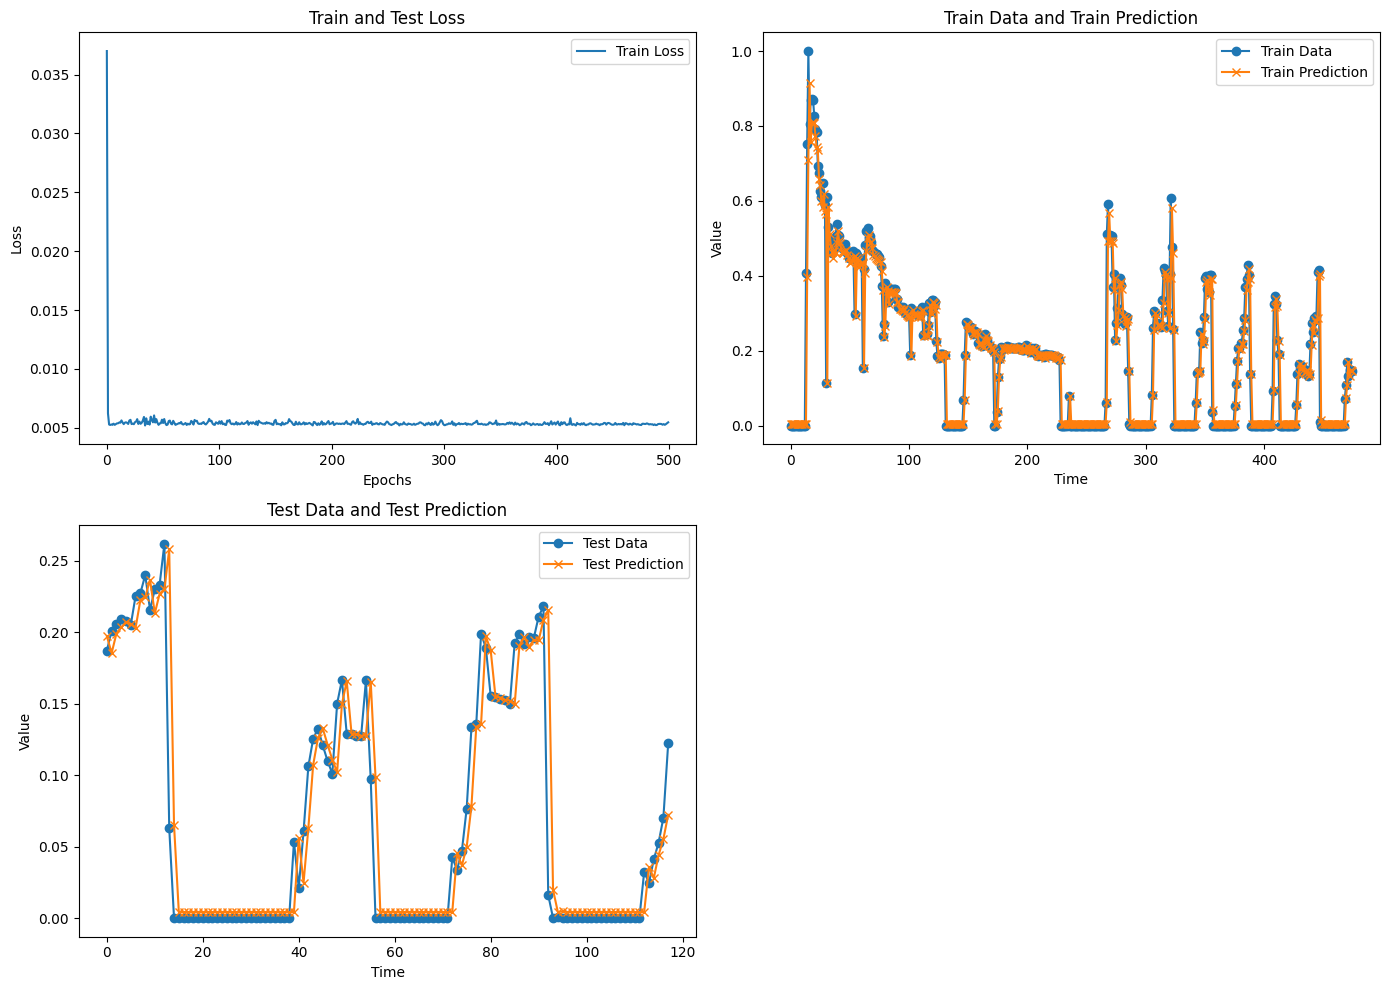

In [60]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

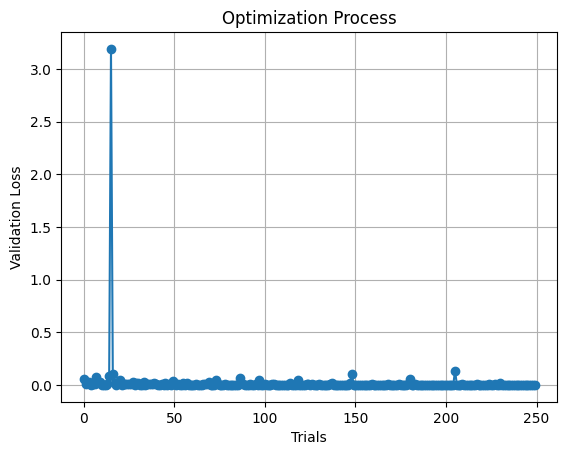

In [61]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

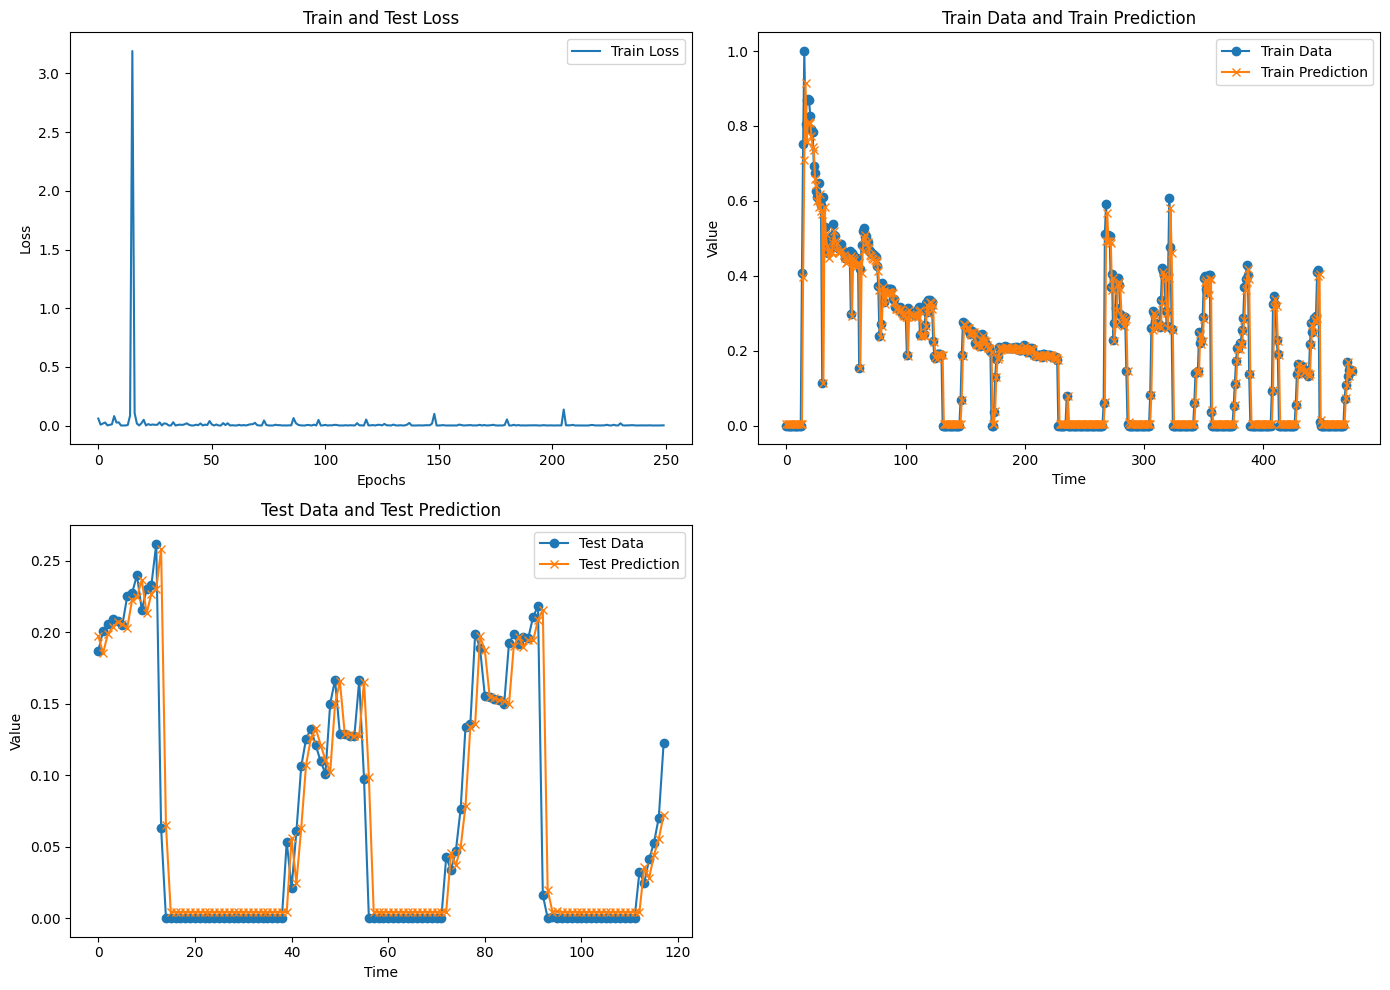

In [62]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [63]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [64]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [65]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [66]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [67]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [68]:
# from keras.utils.vis_utils import plot_model


In [69]:
# plot_model(model_LSTM)

In [70]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [71]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [72]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.005373170462022737
Test MSE: 0.0014282662585843684


In [73]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [74]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.005222  0.001107
1  Baseline   0.005373  0.001428


In [75]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [76]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 25, 'batch_size': 3, 'n_lstm_layers': 11, 'lstm_units': 192, 'learning_rate': 0.004501699349979225}
Trial 2: {'window_size': 54, 'batch_size': 8, 'n_lstm_layers': 14, 'lstm_units': 98, 'learning_rate': 0.009123638610735774}
Trial 3: {'window_size': 30, 'batch_size': 7, 'n_lstm_layers': 5, 'lstm_units': 122, 'learning_rate': 0.009572157697288825}
Trial 4: {'window_size': 11, 'batch_size': 2, 'n_lstm_layers': 19, 'lstm_units': 81, 'learning_rate': 0.0012811029248400976}
Trial 5: {'window_size': 10, 'batch_size': 16, 'n_lstm_layers': 2, 'lstm_units': 83, 'learning_rate': 0.0006329157259476952}
Trial 6: {'window_size': 42, 'batch_size': 10, 'n_lstm_layers': 11, 'lstm_units': 81, 'learning_rate': 0.008545333248344108}
Trial 7: {'window_size': 23, 'batch_size': 14, 'n_lstm_layers': 3, 'lstm_units': 157, 'learning_rate': 0.008481786812437934}
Trial 8: {'window_size': 16, 'batch_size': 10, 'n_lstm_layers': 5, 'lstm_units': 209,